In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Load data into dataframe
xls = pd.ExcelFile('productsales.xlsx')

data = xls.parse('train')
data.head()

,stall_id,product_type,date,number_sold
0,0,0,2010-01-01,801
1,0,0,2010-01-02,810
2,0,0,2010-01-03,818
3,0,0,2010-01-04,796
4,0,0,2010-01-05,808


In [33]:
# Convert the date into formatted date time
# this will help in separating training and testing data
data['date'] = pd.to_datetime(data['date'])

# Get the sum of all sales in a specific day across all stalls and products
daily_sales = data.groupby('date')['number_sold'].sum().reset_index()

# Preview created data frames
training.head(), testing.head()

(            number_sold
 date                   
 2010-01-01        54870
 2010-01-02        54960
 2010-01-03        54863
 2010-01-04        54926
 2010-01-05        54634,
             number_sold
 date                   
 2019-01-01        55221
 2019-01-02        55287
 2019-01-03        55302
 2019-01-04        55407
 2019-01-05        55289)

stall_id
4    35614244
5    32561336
6    31896887
0    30976705
2    29943377
1    26309774
3    12566763
Name: number_sold, dtype: int64


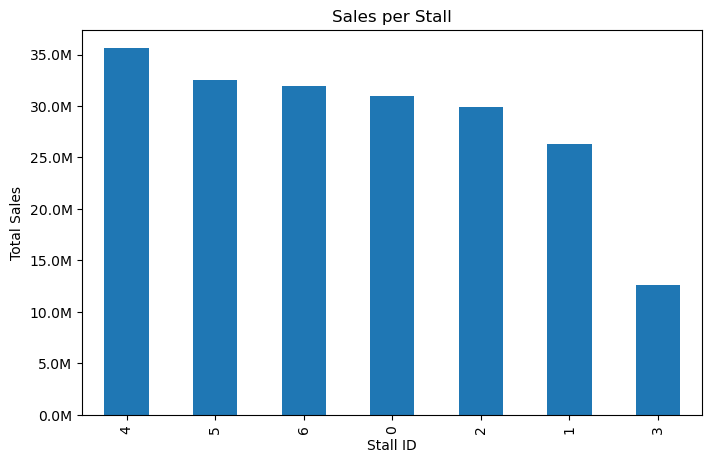

In [34]:
# ===== DESRIPTIVE ANALYTICS =====

# sales per stall
sales_per_stall = data.groupby('stall_id')['number_sold'].sum().sort_values(ascending=False)
fig, ax = plt.subplots()
sales_per_stall.plot(kind='bar', title="Sales per Stall", xlabel='Stall ID', ylabel='Total Sales', figsize=(8,5), ax=ax)
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f'{x/1_000_000:.1f}M')
)
print(sales_per_stall)

product_type
7    21293947
4    20955555
6    20573320
1    20569669
5    20549141
9    20087841
2    19893017
3    18964340
0    18620577
8    18361679
Name: number_sold, dtype: int64


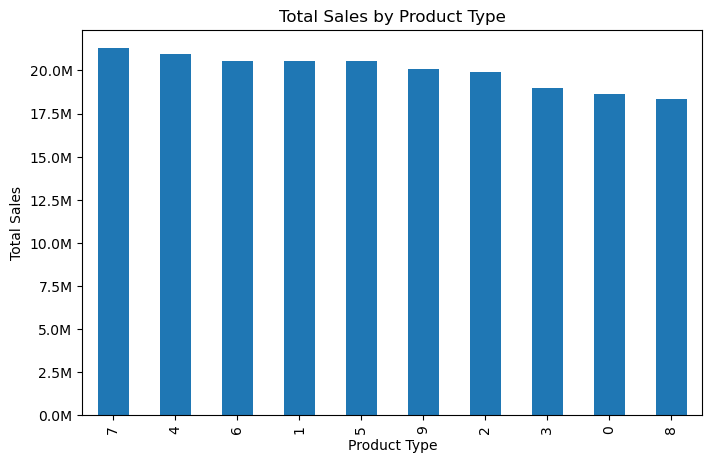

In [35]:
# sales by product
sales_per_product = data.groupby('product_type')['number_sold'].sum().sort_values(ascending=False)
fig, ax = plt.subplots()
sales_per_product.plot(kind='bar', title='Total Sales by Product Type', xlabel='Product Type', ylabel='Total Sales', figsize=(8,5), ax=ax)
ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, _: f'{x/1_000_000:.1f}M')
)
print(sales_per_product)

<Axes: title={'center': 'Total Sales Over Time'}, xlabel='Date'>

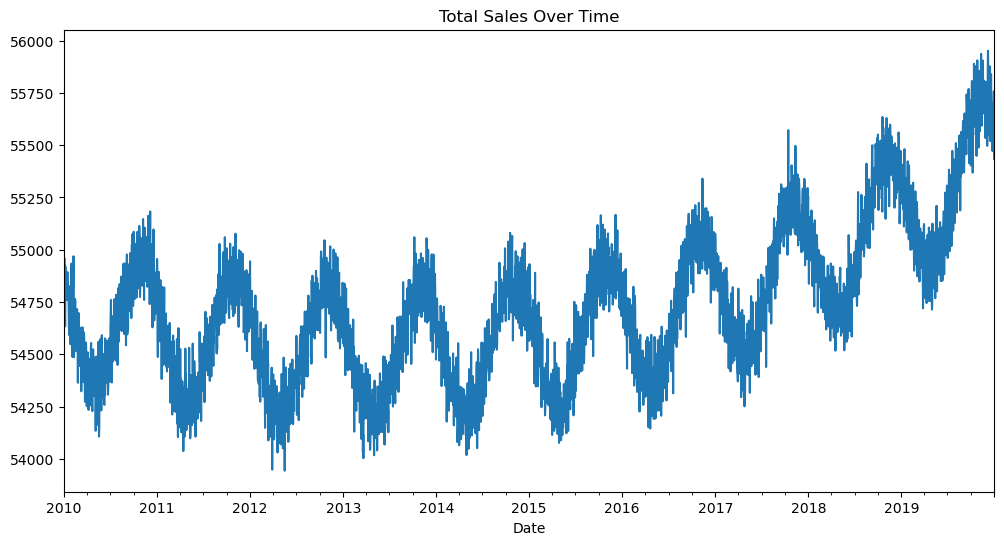

In [36]:
# total sales over time
total_sales_daily = data.groupby('date')['number_sold'].sum()
total_sales_daily.plot(figsize=(12,6), title='Total Sales Over Time', x='Number Sold', xlabel='Date')


In [37]:
# sales statistics
sales_summary = total_sales_daily.describe()
print(sales_summary)

count     3652.000000
mean     54728.665389
std        364.921063
min      53943.000000
25%      54451.000000
50%      54700.000000
75%      54939.000000
max      55952.000000
Name: number_sold, dtype: float64


In [38]:
# stationarity check

from statsmodels.tsa.stattools import adfuller

result = adfuller(total_sales_daily)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("\np-value is > 0.05, data is not stationary.")

ADF Statistic: -2.500075166365028
p-value: 0.11545603704174756

p-value is > 0.05, data is not stationary.


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


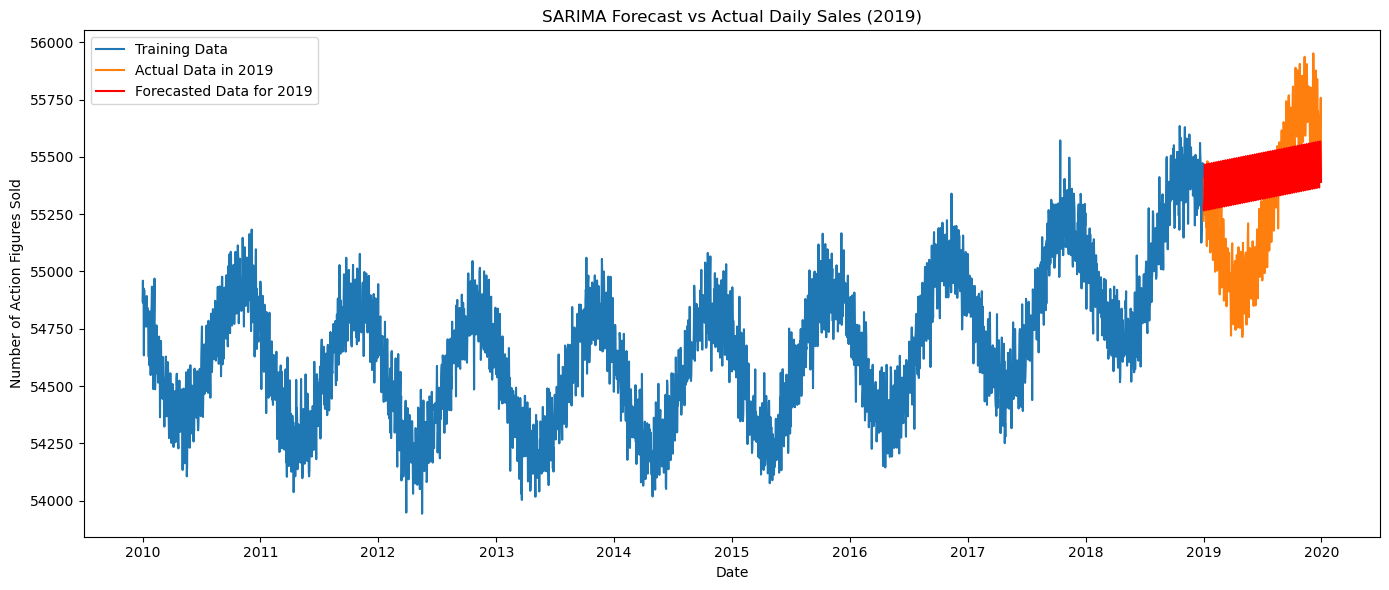

In [ ]:
# create a time series model (SARIMA)

# Split into training and testing data
training = daily_sales[daily_sales['date'].dt.year < 2019].set_index('date')
testing = daily_sales[daily_sales['date'].dt.year == 2019].set_index('date')

from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(training, 
                order=(1, 1, 1), # differencing is applied
                seasonal_order=(1, 1, 1, 7), 
                enforce_stationarity=False,
                enforce_invertibility=False
                )

results = model.fit(disp=False)


forecast = results.predict(start=testing.index[0], end=testing.index[-1])

plt.figure(figsize=(14,6))
plt.plot(training.index, training, label='Training Data')
plt.plot(testing.index, testing, label='Actual Data in 2019')
plt.plot(forecast.index, forecast, label='Forecasted Data for 2019', color='red')
plt.title('SARIMA Forecast vs Actual Daily Sales (2019)')
plt.xlabel('Date')
plt.ylabel('Number of Action Figures Sold')
plt.legend()
plt.tight_layout()
plt.show()

